# Diagnostic Assessment Example

*Last updated 9/3/2019 by Andrew Therriault*

This notebook runs through the diagnostic assessment and shows an example of how the project might be done. There are many other ways to successfully complete the project - this is simply one possibility.

## Loading the data
*Note that the data file used herein has been pre-trimmed to just the necessary variables in order to save space. The column names and values have not been changed from the original, however.*

In [1]:
import pandas as pd
data = pd.read_stata('cces2018_trimmed.dta', index_col='caseid')
data.sample(5).T

caseid,413412827.0,414196990.0,412393820.0,412020911.0,415277174.0
birthyr,1972,1950,1962,1968,1992
gender,Male,Female,Male,Male,Female
educ,4-year,High school graduate,Some college,Post-grad,2-year
race,White,White,White,White,Hispanic
hispanic,No,No,No,No,No
marstat,Never married,Widowed,Married,Married,Never married
region,West,South,Midwest,West,Northeast
CC18_317,Someone else,Hillary Clinton,Donald Trump,Donald Trump,Hillary Clinton


## Tabulating and visualizing vote choice by region

In [2]:
data.groupby('region').CC18_317.value_counts(normalize=True).unstack().round(3).T

region,Northeast,Midwest,South,West
CC18_317,,,,
Donald Trump,0.381,0.415,0.460,0.370
Hillary Clinton,0.517,0.470,0.442,0.489
I did not cast a vote for president,0.007,0.009,0.008,0.011
I don't recall,0.005,0.004,0.005,0.004
Someone else,0.090,0.102,0.086,0.127


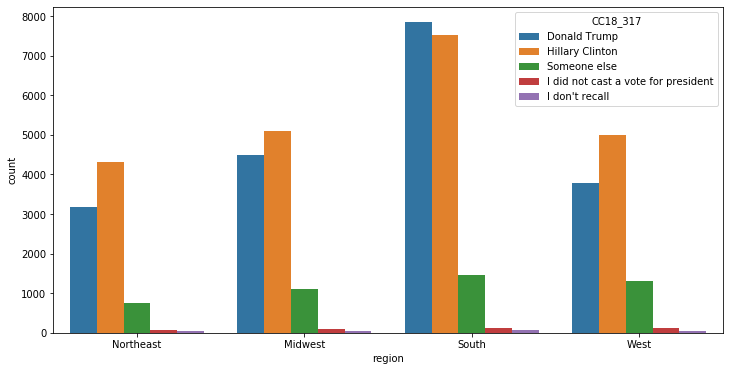

In [3]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
f, ax = plt.subplots(1, figsize=(12,6))
ax = seaborn.countplot(x=data.region, hue=data.CC18_317)

## Calculating Trump vote percentage and confidence intervals by region
*For simplicity, we're only going to look at Clinton and Trump voters for this and subsequent analyses.* 

In [4]:
voters = data[data.CC18_317.fillna('Someone else').map(lambda x: x in ['Donald Trump','Hillary Clinton'])].copy()
voters['vote_trump'] = (voters.CC18_317 == 'Donald Trump').astype(int)

In [5]:
mean = voters.groupby('region').vote_trump.mean()
se = voters.groupby('region').vote_trump.sem()
z = 1.96 #using a 95% confidence interval, so the 95% confidence interval is +/- 1.96 standard errors around the mean

In [6]:
ci = pd.DataFrame()
ci['lower_bound'] = mean - z*se
ci['mean'] = mean
ci['upper_bound'] = mean + z*se
ci.round(3)*100 #making percentages from proportions

,lower_bound,mean,upper_bound
region,,,
Northeast,41.3,42.4,43.5
Midwest,45.9,46.9,47.9
South,50.3,51.1,51.8
West,42.1,43.1,44.1


## Testing the difference in vote choice between males and females

In [7]:
import scipy.stats as ss
male_votes = voters[voters.gender=='Male'].vote_trump
female_votes = voters[voters.gender=='Female'].vote_trump
print('Male Trump Vote %:   {}'.format(100*male_votes.mean()))
print('Female Trump Vote %: {}'.format(100*female_votes.mean()))
print('Difference in %:     {}'.format(100*(male_votes.mean() - female_votes.mean())))
print('P-value:             {}'.format(ss.ttest_ind(male_votes,female_votes)[1]))

Male Trump Vote %:   53.61770194614769
Female Trump Vote %: 41.13308153743613
Difference in %:     12.48462040871156
P-value:             2.2560343556135568e-142


## Creating demographic features

In [8]:
X = pd.DataFrame(index=voters.index)
X['male'] = (voters.gender == 'Male').astype(int)
X['white'] = (voters.race == 'White').astype(int)
X['black'] = (voters.race == 'Black').astype(int)
X['hispanic'] = (voters.hispanic == 'Yes').astype(int)
X['married'] = (voters.marstat == 'Married').astype(int)
X['collegegrad'] = (voters.educ == '4-year').astype(int)
X['gradschool'] = (voters.educ == 'Post-grad').astype(int)
X['born_1951_1960'] = ((voters.birthyr >= 1951) & (voters.birthyr <= 1960)).astype(int)
X['born_1961_1970'] = ((voters.birthyr >= 1961) & (voters.birthyr <= 1970)).astype(int)
X['born_1971_1980'] = ((voters.birthyr >= 1971) & (voters.birthyr <= 1980)).astype(int)
X['born_1981_1990'] = ((voters.birthyr >= 1981) & (voters.birthyr <= 1990)).astype(int)
X['born_1991_2000'] = ((voters.birthyr >= 1991) & (voters.birthyr <= 2000)).astype(int)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
male,41260.0,0.454556,0.497937,0.0,0.0,0.0,1.0,1.0
white,41260.0,0.783640,0.411767,0.0,1.0,1.0,1.0,1.0
black,41260.0,0.091541,0.288381,0.0,0.0,0.0,0.0,1.0
hispanic,41260.0,0.028745,0.167090,0.0,0.0,0.0,0.0,1.0
married,41260.0,0.548934,0.497606,0.0,0.0,1.0,1.0,1.0
collegegrad,41260.0,0.266554,0.442162,0.0,0.0,0.0,1.0,1.0
gradschool,41260.0,0.164542,0.370771,0.0,0.0,0.0,0.0,1.0
born_1951_1960,41260.0,0.205671,0.404196,0.0,0.0,0.0,0.0,1.0
born_1961_1970,41260.0,0.187009,0.389924,0.0,0.0,0.0,0.0,1.0
born_1971_1980,41260.0,0.149152,0.356242,0.0,0.0,0.0,0.0,1.0


## Running a logistic regression of vote choice on demographics

In [9]:
import statsmodels.api as sm
logit = sm.Logit(voters.vote_trump, X)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.607803
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             vote_trump   No. Observations:                41260
Model:                          Logit   Df Residuals:                    41248
Method:                           MLE   Df Model:                           11
Date:                Tue, 03 Sep 2019   Pseudo R-squ.:                  0.1205
Time:                        14:04:10   Log-Likelihood:                -25078.
converged:                       True   LL-Null:                       -28515.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
male               0.3913      0.021     18.475      0.000       0.350       0.433
white              0.4076      0.023     17.923      0.000       0.363       0.452
black             -2.0973      0.064    -32.977      0.000      -2.222      -1.973
hispanic          -0.0011      0.064     -0.017      0.987      -0.127       0.125
married            0.5242      0.021     24.394      0.000       0.482       0.566
collegegrad       -0.6310      0.025    -25.068      0.000      -0.680      -0.582
gradschool        -1.1204      0.031    -36.545      0.000      -1.181      -1.060
born_1951_1960    -0.3878      0.030    -12.965      0.000      -0.446      -0.329
born_1961_1970    -0.2987      0.031     -9.756      0.000      -0.359      -0.239
born_1971_1980    -0.5734      0.033    -17.348      0.000      -0.638      -0.509
born_1981_1990    -0.8686      0.033    -26.181      0.000      -0.934      -0.804
born_1991_2000    -0.7849      0.040    -19.641      0.000      -0.863      -0.707
==================================================================================
"""

In [10]:
margeff = result.get_margeff()
margeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:             vote_trump
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
male               0.0827      0.004     18.768      0.000       0.074       0.091
white              0.0862      0.005     18.204      0.000       0.077       0.095
black             -0.4434      0.013    -34.209      0.000      -0.469      -0.418
hispanic          -0.0002      0.014     -0.017      0.987      -0.027       0.026
married            0.1108      0.004     25.087      0.000       0.102       0.119
collegegrad       -0.1334      0.005    -25.836      0.000      -0.144      -0.123
gradschool        -0.2369      0.006    -39.049      0.000      -0.249      -0.225
born_1951_1960    -0.0820      0.006    -13.066      0.000      -0.094      -0.070
born_1961_1970    -0.0631      0.006     -9.798      0.000      -0.076      -0.051
born_1971_1980    -0.1212      0.007    -17.594      0.000      -0.135      -0.108
born_1981_1990    -0.1836      0.007    -27.048      0.000      -0.197      -0.170
born_1991_2000    -0.1659      0.008    -20.004      0.000      -0.182      -0.150
==================================================================================
"""